# Chapter 11 Reinforcement Learning

In [80]:
import pandas as pd


%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [81]:
# !pip install git+https://github.com/benman1/mab-ranking

We'll download the jester dataset with joke preferences from S3. Here's the location:

In [82]:
URL = "https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-for-Time-Series-with-Python/main/chapter11/jesterfinal151cols.csv"

In [83]:
jester_data = pd.read_csv(URL, header=None)
jester_data.head()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,62,99,99,99,99,0.21875,99,-9.28125,-9.28125,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
1,34,99,99,99,99,-9.68750,99,9.93750,9.53125,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
2,18,99,99,99,99,-9.84375,99,-9.84375,-7.21875,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
3,82,99,99,99,99,6.90625,99,4.75000,-5.90625,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
4,27,99,99,99,99,-0.03125,99,-9.09375,-0.40625,99,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0


We'll make some cosmetic adjustments. The rows refer to users, the columns to jokes.
We can make this clearer:

In [84]:
jester_data.index.name = "users"

The encoding of choices is a bit weird, so we'll fix this as well:

In [85]:
for col in jester_data.columns:
    jester_data[col] = jester_data[col].apply(
        lambda x: 0.0 if x >= 99 or x < 7.0 else 1.0
    )
jester_data.head()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
users,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


So either people chose the joke or they didn't. We'll get rid of people who didn't
choose any joke at all:

In [86]:
jester_data = jester_data[jester_data.sum(axis=1) > 0]

We'll set up our bandits as follows:

In [46]:
from mab_ranking.bandits.rank_bandits import IndependentBandits
from mab_ranking.bandits.bandits import DirichletThompsonSampling

# Create bandits with the data and the number of arms
independent_bandits = IndependentBandits(
    num_arms=jester_data.shape[1], num_ranks=10, bandit_class=DirichletThompsonSampling
)

We choose independent bandits with Thompson sampling from the Beta
distribution. We recommend the best 10 jokes.  

We can then start our simulation. Our hypothetical website has lots of visits, and
we'll get feedback on the 10 jokes that we'll display as chosen by our independent
bandits:

In [88]:
from tqdm import trange

num_steps = 7000
hit_rates = []
for _ in trange(1, num_steps + 1):
    # Select jokes
    selected_items = set(independent_bandits.choose())
    # Pick a users choices at random
    random_user = jester_data.sample().iloc[0, :]
    # Get the jokes that the user has selected
    ground_truth = set(random_user[random_user == 1].index)
    # Get the hit rate of the selected jokes
    hit_rate = len(ground_truth.intersection(selected_items)) / len(ground_truth)
    # Get the feedback
    feedback_list = [1.0 if item in ground_truth else 0.0 for item in selected_items]
    # Update the bandit with the feedback
    independent_bandits.update(selected_items, feedback_list)
    # Append the hit rate to the list
    hit_rates.append(hit_rate)

100%|██████████| 7000/7000 [00:28<00:00, 249.24it/s]


We are simulating 7,000 iterations (visits). At each visit, we'll change our choices
according to the updated reward expectations.  
We can plot the hit rate, the jokes that users are selecting, as follows:

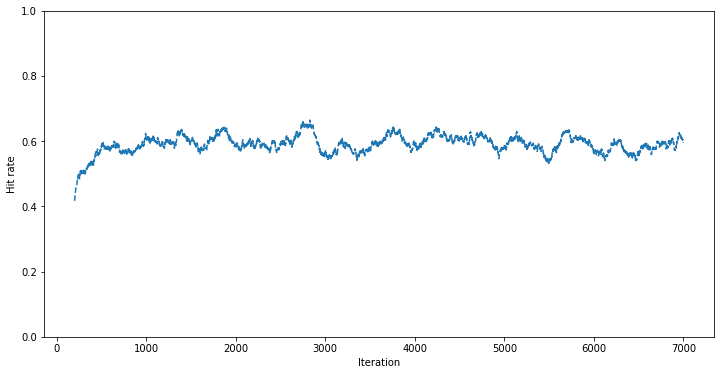

In [49]:
import matplotlib.pyplot as plt


def plot_hit_rates(hit_rates):
    stats = pd.Series(hit_rates)
    plt.figure(figsize=(12, 6))
    plt.plot(stats.index, stats.rolling(200).mean(), "--")
    plt.xlabel("Iteration")
    plt.ylabel("Hit rate")
    plt.ylim(0, 1)


plot_hit_rates(hit_rates)

The mab-ranking library supports contextual information, so we can try out giving
additional information. Let's imagine this information as different user groups
(cohorts). We could think of users who use different search or filter functionality
on our imaginary website, say "newest jokes" or "most popular." Alternatively,
they could be from different regions. Or it could be a timestamp category that
corresponds to the time of the day of visits of users to our website.  

Let's supply the categorical user group information, the context. We'll cluster users
by their preferences, and we'll use the clusters as context:

In [89]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(jester_data)
kmeans = KMeans(n_clusters=5, random_state=0).fit(scaler.transform(jester_data))
# Get the cluster labels
contexts = pd.Series(kmeans.labels_, index=jester_data.index)  #

In [90]:
# reduce the data to 2 dimensions
from sklearn.decomposition import PCA

two_dim_jester = PCA(n_components=2).fit_transform(jester_data)
two_dim_jester_df = pd.DataFrame(two_dim_jester, index=jester_data.index)
two_dim_jester_df["context"] = contexts
two_dim_jester_df.columns = ["PCA1", "PCA2", "context"]
two_dim_jester_df.head()

,PCA1,PCA2,context
users,,,
0,1.956900,-0.507166,2
1,0.574071,1.016476,2
2,-0.598211,-0.166810,0
3,-0.193421,-0.217831,0
4,-0.206538,0.129406,0


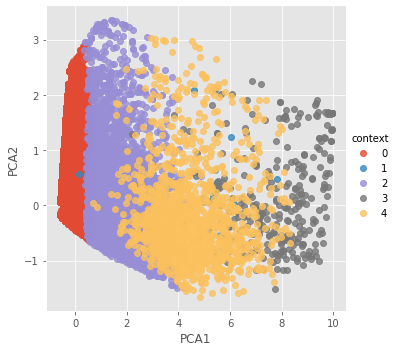

In [91]:
# visualize the clusters in 2D
import seaborn as sns

sns.lmplot(
    x="PCA1",
    y="PCA2",
    data=two_dim_jester_df,
    hue="context",
    fit_reg=False,
)

This creates 5 user groups.
We'll have to reset our bandits:

In [92]:
independent_bandits = IndependentBandits(
    num_arms=jester_data.shape[1], num_ranks=10, bandit_class=DirichletThompsonSampling
)

Then, we can redo our simulation. Only now, we'll supply the user context:

In [93]:
hit_rates = []
for _ in trange(1, num_steps + 1):
    # pick a user's choices at random
    random_user = jester_data.sample().iloc[0, :]
    # get the context of the user
    context = {"previous_action": contexts.loc[random_user.name]}
    # select jokes
    selected_items = set(independent_bandits.choose(context=context))
    # get the jokes that the user has selected
    ground_truth = set(random_user[random_user == 1].index)
    # get the hit rate of the selected jokes
    hit_rate = len(ground_truth.intersection(selected_items)) / len(ground_truth)
    # get the feedback
    feedback_list = [1.0 if item in ground_truth else 0.0 for item in selected_items]
    # update the bandit with the feedback
    independent_bandits.update(selected_items, feedback_list, context=context)
    # append the hit rate to the list
    hit_rates.append(hit_rate)

100%|██████████| 7000/7000 [00:29<00:00, 238.34it/s]


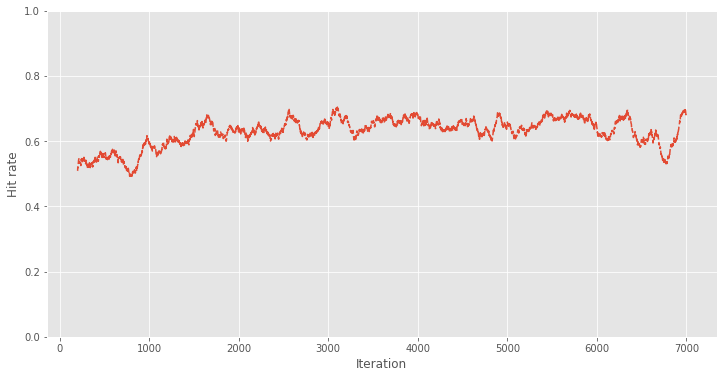

In [94]:
plot_hit_rates(hit_rates)

We can see that the hit rate is a bit higher than before.  

This model ignores the order of the recommended jokes on our hypothetical website.
There are other bandit implementations that model the ranks.  

I'll leave it to the reader to play around with this more. A fun exercise is to create a probabilistic model of reward expectations.

In the next section, we'll be playing around with a deep Q-learning trading bot.
This is a more intricate model and will require more attention. We'll apply this to
cryptocurrency trading.

## Trading with DQN

This is based on a tutorial of the TensorTrade library, which we'll use in this
example. TensorTrade is a framework for building, training, evaluating, and
deploying robust trading algorithms using reinforcement learning.   

TensorTrade relies on existing tools such as OpenAI Gym, Keras, and TensorFlow to
enable fast experimentation with algorithmic trading strategies. We'll install it with
pip as usual. We'll make sure we install the latest version from GitHub:

In [54]:
# !pip install git+https://github.com/tensortrade-org/tensortrade.git

We could also install the ta library, which can provide additional signals useful for
trading, but we'll leave this out here.  

Let's get a few imports out of the way:

In [55]:
import tensortrade.env.default as default
from tensortrade.data.cdd import CryptoDataDownload
from tensortrade.feed.core import Stream, DataFeed
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.agents import DQNAgent

/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/time-series-analysis-book-Kh4ECq7S-py3.9/lib/python3.9/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/time-series-analysis-book-Kh4ECq7S-py3.9/lib/python3.9/site-packages/keras/utils/image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/time-series-analysis-book-Kh4ECq7S-py3.9/lib/python3.9/site-packages/keras/utils/image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/time-series-analysis-book-

These imports concern utilities for the (simulated) exchange, the portfolio, and the
environment. Further, there are utilities for data loading and feeding it into the
simulation, constants for currency conversion, and finally, there's a deep Q-agent,
which consists of a Deep Q-Network (DQN).  

Please note that the matplotlib magic command (%matplotlib inline) is needed for
the Plotly charts to show up as expected.  

As a first step, let's load a dataset of historical cryptocurrency prices:

In [56]:
cdd = CryptoDataDownload()
data = cdd.fetch("Bitstamp", "USD", "BTC", "1h")
data.head()

,date,unix,open,high,low,close,volume
0,2018-05-15 06:00:00,1526364000,8733.86,8796.68,8707.28,8740.99,559.93
1,2018-05-15 07:00:00,1526367600,8740.99,8766.00,8721.11,8739.00,273.58
2,2018-05-15 08:00:00,1526371200,8739.00,8750.27,8660.53,8728.49,917.79
3,2018-05-15 09:00:00,1526374800,8728.49,8754.40,8701.35,8708.32,182.62
4,2018-05-15 10:00:00,1526378400,8708.32,8865.00,8695.11,8795.90,1260.69


This dataset consists of hourly Bitcoin prices in US dollars. 

We'll add a relative strength indicator signal, a technical indicator for the financial
markets. It measures the strength or weakness of a market by comparing the closing
prices of a recent trading period. We'll also add a moving average convergence/
divergence (MACD) indicator, which is designed to reveal changes in the strength,
direction, momentum, and duration of a trend.  

These two are defined as follows:

In [57]:
def relative_strength_index(price: Stream[float], period: float) -> Stream[float]:
    """
    Relative strength index (RSI) is a momentum indicator that measures the speed
    and change of price movements.
    It is considered a momentum indicator because it is designed to indicate both
    the current strength of an asset's movement and its potential strength of
    future movements.
    """
    delta = price.diff()
    upside = delta.clamp_min(0).abs()
    downside = delta.clamp_max(0).abs()
    relative_strength = (
        upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    )
    return 100 * (1 - (1 + relative_strength) ** (-1))

In [60]:
def moving_average_convergence_divergence(
    price: Stream[float], fast: float, slow: float, signal: float
) -> Stream[float]:
    """
    Moving average convergence-divergence (MACD) is a trend-following momentum
    indicator that shows the relationship between two moving averages of prices.
    The MACD is calculated by subtracting the 26-period exponential moving
    average (EMA) from the 12-period EMA.
    """
    fast_ema = price.ewm(span=fast, adjust=False).mean()
    slow_ema = price.ewm(span=slow, adjust=False).mean()
    # MACD is the difference between the fast and slow EMA
    macd = fast_ema - slow_ema
    # Signal line is 9-period EMA of MACD
    signal = macd - macd.ewm(span=signal, adjust=False).mean()
    return signal

Alternatively, here we could be using trading signals from the ta library.  

We'll now set up the feed that goes into our decision making:

In [58]:
features = []
for col in data.columns:
    s = Stream.source(list(data[col]), dtype="float").rename(data[col].name)
    features += [s]

closing_price = Stream.select(features, lambda s: s.name == "close")

We are selecting the closing price as a feature.  
Now, we'll add our indicators as additional features:

In [62]:
features = [
    closing_price.log().diff().rename("lr"),
    relative_strength_index(closing_price, period=20).rename("rsi"),
    moving_average_convergence_divergence(
        closing_price, fast=10, slow=50, signal=5
    ).rename("macd"),
]

feed = DataFeed(features)
feed.compile()

Aside from RSI and MACD, we are also adding a trend indicator (LR).
We can have a look at the first five lines from the data feed:

In [63]:
for i in range(5):
    print(feed.next())

{'lr': nan, 'rsi': nan, 'macd': 0.0}
{'lr': -0.00022768891842694927, 'rsi': 0.0, 'macd': -0.1891859774210995}
{'lr': -0.0012033785355889393, 'rsi': 0.0, 'macd': -1.2726616061000744}
{'lr': -0.0023134975946028646, 'rsi': 0.0, 'macd': -3.6577343503541435}
{'lr': 0.01000681330867259, 'rsi': 74.26253567956897, 'macd': 3.7087743627464844}


Let's set up the broker:

In [66]:
bitstamp = Exchange("bitstamp", service=execute_order)(
    Stream.source(list(data["close"]), dtype="float").rename("USD-BTC")
)

The exchange is the interface that will let us execute orders. An exchange needs
a name, an execution service, and streams of price data. Currently, TensorTrade
supports a simulated execution service using simulated or stochastic data.  

Now we need a portfolio:

In [67]:
portfolio = Portfolio(USD, [Wallet(bitstamp, 10000 * USD), Wallet(bitstamp, 10 * BTC)])

A portfolio can be any combination of exchanges and instruments that the exchange
supports.  

TensorTrade includes lots of monitoring tools, called renderers, which can be
attached to the environment. They can draw a chart (PlotlyTradingChart) or log to a
file (FileLogger), for example. Here's our setup:

In [68]:
# Create the agent
renderer_feed = DataFeed(
    [
        Stream.source(list(data["date"])).rename("date"),
        Stream.source(list(data["open"]), dtype="float").rename("open"),
        Stream.source(list(data["high"]), dtype="float").rename("high"),
        Stream.source(list(data["low"]), dtype="float").rename("low"),
        Stream.source(list(data["close"]), dtype="float").rename("close"),
        Stream.source(list(data["volume"]), dtype="float").rename("volume"),
    ]
)

Finally, here's the trading environment, which is an instance of the OpenAI Gym (the
OpenAI Gym provides a wide variety of simulated environments):

In [69]:
env = default.create(
    portfolio=portfolio,
    action_scheme="managed-risk",
    reward_scheme="risk-adjusted",
    feed=feed,
    renderer_feed=renderer_feed,
    renderer=default.renderers.PlotlyTradingChart(),
    window_size=20,
)

Let's check the Gym feed:

In [70]:
env.observer.feed.next()

{'internal': {'bitstamp:/USD-BTC': 8740.99,
  'bitstamp:/USD:/free': 10000.0,
  'bitstamp:/USD:/locked': 0.0,
  'bitstamp:/USD:/total': 10000.0,
  'bitstamp:/BTC:/free': 10.0,
  'bitstamp:/BTC:/locked': 0.0,
  'bitstamp:/BTC:/total': 10.0,
  'bitstamp:/BTC:/worth': 87409.9,
  'net_worth': 97409.9},
 'external': {'lr': nan, 'rsi': nan, 'macd': 0.0},
 'renderer': {'date': Timestamp('2018-05-15 06:00:00'),
  'open': 8733.86,
  'high': 8796.68,
  'low': 8707.28,
  'close': 8740.99,
  'volume': 559.93}}

This is what the trading bot will be able to rely on for making decisions on executing
trades.  
Now we can set up and train our DQN trading agent:

In [71]:
agent = DQNAgent(env)
agent.train(n_steps=200, n_episodes=2, save_path="agents/")

/var/folders/63/m20qx7592pb4b2zvqmy711qc0000gn/T/ipykernel_66011/179255854.py:1: DeprecationWarning: Call to deprecated class DQNAgent. (Builtin agents are being deprecated in favor of external implementations (ie: Ray)) -- Deprecated since version 1.0.4.
  agent = DQNAgent(env)
/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/time-series-analysis-book-Kh4ECq7S-py3.9/lib/python3.9/site-packages/deprecated/classic.py:173: DeprecationWarning: Call to deprecated class Agent. (Builtin agents are being deprecated in favor of external implementations (ie: Ray)) -- Deprecated since version 1.0.4.
  return old_new1(cls, *args, **kwargs)
2022-07-29 01:24:49.129071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/frankkell

====      AGENT ID: 5d855224-765d-4d0c-a10c-32b142bedfa9      ====


FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candle…

FigureWidget({
    'data': [{'close': array([8740.99, 8739.  , 8728.49, 8708.32, 8795.9 , 8760.  , 8760.  , 87…

FigureWidget({
    'data': [{'close': array([8740.99, 8739.  , 8728.49, 8708.32, 8795.9 , 8760.  , 8760.  , 87…

FigureWidget({
    'data': [{'close': array([8740.99, 8739.  , 8728.49, 8708.32, 8795.9 , 8760.  , 8760.  , 87…

FigureWidget({
    'data': [{'close': array([8740.99, 8739.  , 8728.49, 8708.32, 8795.9 , 8760.  , 8760.  , 87…

FigureWidget({
    'data': [{'close': array([8740.99, 8739.  , 8728.49, 8708.32, 8795.9 , 8760.  , 8760.  , 87…

FigureWidget({
    'data': [{'close': array([8740.99, 8739.  , 8728.49, 8708.32, 8795.9 , 8760.  , 8760.  , 87…

FigureWidget({
    'data': [{'close': array([8740.99, 8739.  , 8728.49, 8708.32, 8795.9 , 8760.  , 8760.  , 87…

FigureWidget({
    'data': [{'close': array([8740.99, 8739.  , 8728.49, 8708.32, 8795.9 , 8760.  , 8760.  , 87…

FigureWidget({
    'data': [{'close': array([8740.99, 8739.  , 8728.49, 8708.32, 8795.9 , 8760.  , 8760.  , 87…

-1294803.5706693144

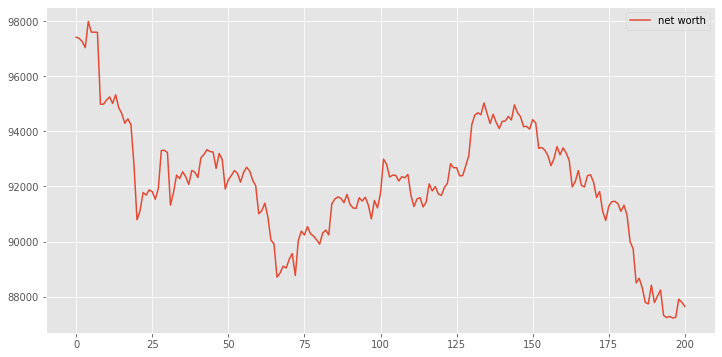

In [79]:
# plot the agent's performance
df = pd.DataFrame(portfolio.performance).T
df.net_worth.plot(figsize=(12, 6))
plt.legend(["net worth"])